# Breast Cancer Prediction [Project](https://github.com/SJSUMS/Breast-Tumor-Classification-on-PCam)
- Transfer Learning
- Model = MobileNet2

by [Mavis Wang](https://github.com/mavisw)

## Data

[PatchCamelyon](https://paperswithcode.com/dataset/pcam) is an image classification dataset. It consists of 327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annotated with a binary label indicating presence of metastatic tissue. PCam provides a new benchmark for machine learning models: bigger than CIFAR10, smaller than ImageNet, trainable on a single GPU.


In [89]:
# import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, datetime, time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import Input 
from tensorflow.keras import callbacks, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax, Nadam,Ftrl
from keras.layers import Dense, Conv2D, LSTM, Attention, Flatten, GlobalAveragePooling2D
from keras.layers import BatchNormalization, MaxPooling2D, Dropout
from keras.layers import Reshape, UpSampling2D
from tensorflow.keras.metrics import Accuracy,Precision,Recall,AUC

# path = '/content/drive/MyDrive/Colab Notebooks/PCam/'


## load data

Since the dataset is over 200k, we take testing set (30k) as our sample dataset for this project as our train/test/val sets.

In [ ]:
# # store data in dict
# miniPcam_dict = {'data': x,'target': y}

# # save data
# from pickle import dump
# dump(miniPcam_dict, open(path + 'data/miniPcam_dict.pkl', 'wb'))

In [ ]:
# load data
from pickle import load
data = load(open(path + 'data/miniPcam_dict.pkl', 'rb'))

# unpack
x, y = data.values()

In [ ]:
print(x.shape)
print(y.shape)

(32768, 96, 96, 3)
(32768, 1)


## Pre-process

### one-hot encoder

In [ ]:
# num_of_class
num_classes = 2

# one-hot
y = to_categorical(y, num_classes)

In [ ]:
y.shape

(32768, 2)

### split

In [7]:
# 20% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2,
                                                    shuffle=True)

# reserve 6500 samples for validation
x_train = x_train[:-6500]
y_train = y_train[:-6500]
x_val = x_train[-6500:]
y_val = y_train[-6500:]

NameError: name 'x' is not defined

In [ ]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(19714, 2)
(6500, 2)
(6554, 2)


### annotation / label encoder
Patches denotes the presence of tumour with a positive label whereas the other two have negative labels.

1 = tumor, 0 = normal

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(['Normal','Tumor'])
list(le.classes_)
# print(le.inverse_transform([0]))

['Normal', 'Tumor']

## visualize

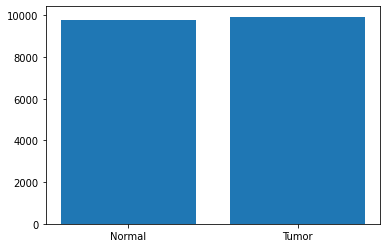

In [ ]:
# label distribution
label_df = pd.DataFrame(y_train.reshape(-1,2))
cat = list(le.classes_)
freq = np.sum(label_df, axis=0)

plt.bar(cat, freq)
plt.show()

In [ ]:
# training sample
label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19714 entries, 0 to 19713
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       19714 non-null  float32
 1   1       19714 non-null  float32
dtypes: float32(2)
memory usage: 154.1 KB


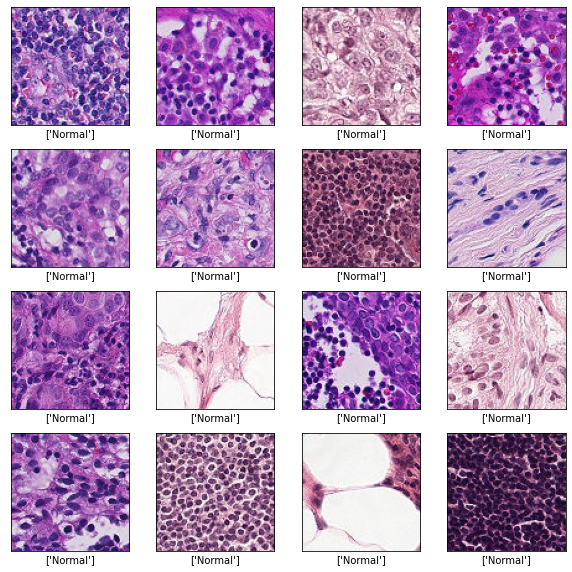

In [ ]:
# from tensorflow.keras.preprocessing import image

plt.figure(figsize=(10,10))
for i in range (16):
    plt.subplot(4,4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.array_to_img(x_test[i]))
    plt.xlabel(le.inverse_transform([np.argmax(y_test[i])]))
    # plt.xlabel(np.argmax(y_test[i]))

## load split data

In [ ]:
# store data in dict
miniPcam_split = {'x_train': x_train,'y_train': y_train, 'x_val': x_val, 'y_val': y_val, 'x_test': x_test, 'y_test': y_test}

# save data
from pickle import dump
dump(miniPcam_split, open(path + '/data/miniPcam_split.pkl', 'wb'))

In [8]:
# load data
from pickle import load
data = load(open(path + '/data/miniPcam_split.pkl', 'rb'))


# unpack
x_train, y_train, x_val, y_val, x_test, y_test = data.values()

## generator / augmentation

In [9]:
batch_size = 64

train_steps_per_epoch = len(x_train) // batch_size
valid_steps_per_epoch = len(x_val) // batch_size

# augmented & normalization
train_datagen = image.ImageDataGenerator(rescale=1.0/255.0,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         rotation_range=45,
                                         channel_shift_range=0.2,
                                         horizontal_flip=True)
# normaliziation only
test_datagen = image.ImageDataGenerator(rescale=1.0/255.0)

# data generator
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
valid_generator = test_datagen.flow( x_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

In [10]:
# fist batch img, lable
(valid_generator.next()[0]).shape

(64, 96, 96, 3)

In [11]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

print(x_test.shape)
print(y_test.shape)

(19714, 96, 96, 3)
(19714, 2)
(6500, 96, 96, 3)
(6500, 2)
(6554, 96, 96, 3)
(6554, 2)


## Save sample test batch images

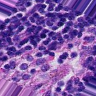

(6, 96, 96, 3)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

img_path = path + '/images/'

# generate 1st random batch and save to folder
sample_imgs = next(train_datagen.flow(x_test, batch_size=6, shuffle=True,
                             save_to_dir= img_path, save_prefix='test_sample', save_format='jpeg'))

display(image.array_to_img(sample_imgs[0]))
print(sample_imgs.shape)

# MobileNetV2
MobileNetV2 is very similar to the original MobileNet, except that it uses inverted residual blocks with bottlenecking features. It has a drastically lower parameter count than the original MobileNet. MobileNets support any input size greater than 32 x 32, with larger image sizes offering better performance.

**Why MobileNet2**
* memory efficient inference on device intelligence.
* tradeoff between accuracy, computation, and siz of params.

**Applications**
* Classification
* Object detection
* Fine-grain classification
* Face attributes
* Large-scale geo-localization

**Paper:** 
* [MobileNetV2: Inverted Residuals and Linear Bottlenecks](https://arxiv.org/abs/1801.04381)
* [MobileNets: Efficient Convolutional Neural Networks for Mobile Vision](https://arxiv.org/pdf/1704.04861.pdf)

## M0: mobileNet2NN

Use mobileNetV2 as backbone

In [80]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

In [81]:
(IMG_W, IMG_H, IMG_C) = (96,96,3)

# default config
lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'elu'
loss = 'binary_crossentropy'
metrics = ['accuracy']

# pretrained model
def feature_extractor(inputs):
    features = MobileNetV2(
      input_shape = (IMG_W, IMG_H, IMG_C),
      include_top = False,
      weights=None)(inputs)
    return features

def classifier(inputs):
  # connector
    x = layers.GlobalAveragePooling2D()(inputs)
    x = layers.Flatten()(x)
  
  # additional layers
    x = layers.Dense(1024, activation=act)(x)
    x = layers.Dense(512, activation=act)(x)
  
    output = layers.Dense(2, activation='sigmoid', name='predictions')(x)
    return output

# build model
def mobileNet2NN(input_shape=(IMG_W, IMG_H, IMG_C), n_class=2):
    n_classes = n_class
    input_shape = input_shape
    model_name = 'mobileNet2NN'

    feature_mobileNet = feature_extractor(inputs)
    class_output = classifier(feature_mobileNet)

    model = Model(inputs=inputs, outputs=class_output, name=model_name)
    model.compile(loss=loss, optimizer = opt, metrics= metrics)
  
    return model

In [82]:
# train, evaluate, plot
# save
callbacks = [keras.callbacks.ModelCheckpoint(path + 'checkpoints/pcam_ep{epoch}.h5', 
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode = 'max'
                                             )]
def train_model(model):
    start = time.time()
    hist = model.fit(train_generator,
                     epochs = n_epochs,
                     verbose = 1, 
                     validation_data = valid_generator,
                     steps_per_epoch = train_steps_per_epoch,
                     validation_steps = valid_steps_per_epoch,
                     shuffle = True,
                     callbacks=callbacks)
    stop = time.time()
    training_time = stop - start
    print(f'Total training time = {training_time}s')
    
    model.save_weights(path + f'models/{model.name}_weights.h5')
    model.save(path + f'models/{model.name}.h5')
    
    return hist, model

# evaluate model loss & accuracy on test set
def eval_model(model):
    score = model.evaluate(test_generator)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])

    return score

# plot
def plot_model(hist):
    # loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.plot()
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # accuracy
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valication'], loc='lower right')
    plt.show()

# run and test model
def run_all(model):
    hist, model = train_model(model)
    eval_model(model)
    plot_model(hist)

    return model

In [83]:
mobileNet2NN = run_all(mobileNet2NN(2))

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
  9/308 [..............................] - ETA: 5:12 - loss: 0.7672 - accuracy: 0.5382

KeyboardInterrupt: 

## M1: selu_mobileNet2


In [ ]:
(IMG_W, IMG_H, IMG_C) = (96,96,3)

# default config
lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'selu'
loss = 'binary_crossentropy'
metrics = ['accuracy']

# pretrained model
def feature_extractor(inputs):
  features = MobileNetV2(
      input_shape = (IMG_W, IMG_H, IMG_C),
      include_top = False,
      weights='imagenet')(inputs)
  return features

def classifier(inputs):
  # connector
  x = layers.GlobalAveragePooling2D()(inputs)
  x = layers.Flatten()(x)
  
  # additional layers
  x = layers.Dense(1024, activation=act)(x)
  x = layers.Dense(512, activation=act)(x)
  
  output = layers.Dense(2, activation='sigmoid', name='predictions')(x)
  return output

# build model
def base_mobileNet2(input_shape=(IMG_W, IMG_H, IMG_C), n_class=2):
  n_classes = n_class
  input_shape = input_shape
  model_name = 'base_mobileNet2'

  feature_mobileNet = feature_extractor(inputs)
  class_output = classifier(feature_mobileNet)

  model = Model(inputs=inputs, outputs=class_output, name=model_name)
  model.compile(loss=loss, optimizer = opt, metrics= metrics)
  
  return model
  
# define input layer
inputs = Input(shape=(96,96,3))
base_mobileNet2(inputs).summary()

Model: "base_mobileNet2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d_16  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_16 (Flatten)        (None, 1280)              0         
                                                                 
 dense_35 (Dense)            (None, 1024)              1311744   
                                                                 
 dense_36 (Dense)            (None, 512)           

### utility: train and evaluate

In [22]:
import time
n_epochs = 20

# save
callbacks = [keras.callbacks.ModelCheckpoint(path + 'checkpoints/pcam_ep{epoch}.h5', 
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode = 'max'
                                             )]
#  train
def train_model(model):
    start = time.time()
    hist = model.fit(train_generator,
                     epochs = n_epochs,
                     verbose = 1, 
                     validation_data = valid_generator,
                     steps_per_epoch = train_steps_per_epoch,
                     validation_steps = valid_steps_per_epoch,
                     shuffle = True,
                     callbacks=callbacks)
    stop = time.time()
    training_time = stop - start
    print(f'Total training time = {training_time}s')
    
    model.save_weights(path + f'models/{model.name}_weights.h5')
    model.save(path + f'models/{model.name}.h5')
    
    return hist, model

# evaluate model loss & accuracy on test set
def eval_model(model):
    score = model.evaluate(test_generator)
    return score

# plot
def plot_model(hist):
    # loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.plot()
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # accuracy
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valication'], loc='lower right')
    plt.show()

# run and test model
def run_all(model):
    hist, model = train_model(model)
    eval_model(model)
    plot_model(hist)

    return model

Epoch 1/20
308/308 [==============================] - 84s 252ms/step - loss: 0.3613 - accuracy: 0.8458 - val_loss: 2.0054 - val_accuracy: 0.5582
Epoch 2/20
308/308 [==============================] - 76s 245ms/step - loss: 0.2545 - accuracy: 0.8938 - val_loss: 0.4121 - val_accuracy: 0.8334
Epoch 3/20
308/308 [==============================] - 75s 242ms/step - loss: 0.2138 - accuracy: 0.9132 - val_loss: 0.5329 - val_accuracy: 0.8157
Epoch 4/20
308/308 [==============================] - 75s 243ms/step - loss: 0.1862 - accuracy: 0.9256 - val_loss: 0.5997 - val_accuracy: 0.8153
Epoch 5/20
308/308 [==============================] - 75s 243ms/step - loss: 0.1673 - accuracy: 0.9346 - val_loss: 0.5362 - val_accuracy: 0.8205
Epoch 6/20
308/308 [==============================] - 75s 243ms/step - loss: 0.1526 - accuracy: 0.9421 - val_loss: 0.4339 - val_accuracy: 0.8413
Epoch 7/20
308/308 [==============================] - 75s 243ms/step - loss: 0.1379 - accuracy: 0.9478 - val_loss: 0.2930 - val_ac

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


103/103 [==============================] - 5s 44ms/step - loss: 0.6074 - accuracy: 0.8117
Test loss: 0.6074368953704834
Test accuracy: 0.8117180466651917


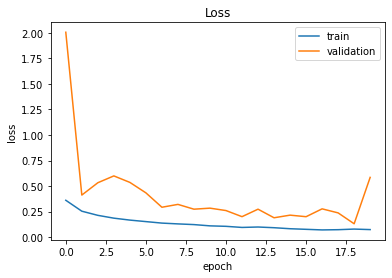

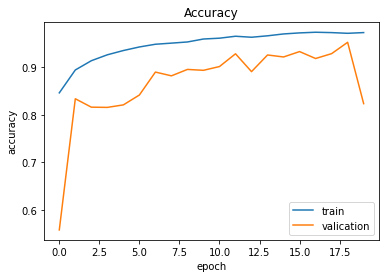

In [ ]:
# selu
inputs = Input(shape=(96,96,3))
base_mobileNet2 = run_all(base_mobileNet2(inputs))

## M2: elu_mobileNet2

In [65]:
(IMG_W, IMG_H, IMG_C) = (96,96,3)

# default config
lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'elu'
loss = 'binary_crossentropy'
metrics = ['accuracy']
n_epochs = 20


# pretrained model
def feature_extractor(inputs):
    features = MobileNetV2(
    input_shape = (IMG_W, IMG_H, IMG_C),
    include_top = False,
    weights='imagenet')(inputs)
    return features

def classifier(inputs):
  # connector
    x = layers.GlobalAveragePooling2D()(inputs)
    x = layers.Flatten()(x)
  
  # additional layers
    x = layers.Dense(1024, activation=act)(x)
    x = layers.Dense(512, activation=act)(x)
  
    output = layers.Dense(2, activation='sigmoid', name='predictions')(x)
    return output

# build model
def elu_mobileNet2(input_shape=(IMG_W, IMG_H, IMG_C), n_class=2):
    n_classes = n_class
    input_shape = input_shape
    model_name = 'elu_mobileNet2'

    feature_mobileNet = feature_extractor(inputs)
    class_output = classifier(feature_mobileNet)

    model = Model(inputs=inputs, outputs=class_output, name=model_name)
    model.compile(loss=loss, optimizer = opt, metrics= metrics)
  
    return model


# training pipeline
# save
callbacks = [keras.callbacks.ModelCheckpoint(path + 'checkpoints/pcam_ep{epoch}.h5', 
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode = 'max'
                                             )]
#  train
def train_model(model):
    start = time.time()
    hist = model.fit(train_generator,
                     epochs = n_epochs,
                     verbose = 1, 
                     validation_data = valid_generator,
                     steps_per_epoch = train_steps_per_epoch,
                     validation_steps = valid_steps_per_epoch,
                     shuffle = True,
                     callbacks=callbacks)
    stop = time.time()
    training_time = stop - start
    print(f'Total training time = {training_time}s')
    
    model.save_weights(path + f'models/{model.name}_weights.h5')
    model.save(path + f'models/{model.name}.h5')
    
    return hist, model

# evaluate model loss & accuracy on test set
def eval_model(model):
    score = model.evaluate(test_generator)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])

    return score

# plot
def plot_model(hist):
    # loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.plot()
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # accuracy
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valication'], loc='lower right')
    plt.show()

# run and test model
def run_all(model):
    hist, model = train_model(model)
    eval_model(model)
    plot_model(hist)

    return model

In [ ]:
# define input layer
inputs = Input(shape=(96,96,3))
elu_mobileNet2 = run_all(elu_mobileNet2(inputs))

9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/20
308/308 [==============================] - 82s 246ms/step - loss: 0.3386 - accuracy: 0.8494 - val_loss: 1.8314 - val_accuracy: 0.5520
Epoch 2/20
308/308 [==============================] - 74s 239ms/step - loss: 0.2353 - accuracy: 0.9056 - val_loss: 1.4611 - val_accuracy: 0.6957
Epoch 3/20
308/308 [==============================] - 74s 241ms/step - loss: 0.1957 - accuracy: 0.9221 - val_loss: 0.6410 - val_accuracy: 0.8173
Epoch 4/20
308/308 [==============================] - 76s 245ms/step - loss: 0.1707 - accuracy: 0.9342 - val_loss: 0.5001 - val_accuracy: 0.8246
Epoch 5/20
308/308 [==============================] - 74s 241ms/step - loss: 0.1574 - accuracy: 0.9397 - val_loss: 0.4701 - val_accuracy: 0.8260
Epoch 6/20
308/308 [==============================] - 75s 243ms/step - loss: 0.1479 - accuracy: 0.9427 - val_loss: 0.3081 - val_accuracy: 0.8680
Epoch 7/20
308/308 [==============================] - 75s 244ms/ste

## M3: relu_mobileNet2

In [ ]:
(IMG_W, IMG_H, IMG_C) = (96,96,3)

# default config
lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'relu'
loss = 'binary_crossentropy'
metrics = ['accuracy']

# pretrained model
def feature_extractor(inputs):
    features = MobileNetV2(
    input_shape = (IMG_W, IMG_H, IMG_C),
    include_top = False,
    weights='imagenet')(inputs)
    return features

def classifier(inputs):
  # connector
    x = layers.GlobalAveragePooling2D()(inputs)
    x = layers.Flatten()(x)
  
  # additional layers
    x = layers.Dense(1024, activation=act)(x)
    x = layers.Dense(512, activation=act)(x)
  
    output = layers.Dense(2, activation='sigmoid', name='predictions')(x)
    return output

# build model
def relu_mobileNet2(input_shape=(IMG_W, IMG_H, IMG_C), n_class=2):
    n_classes = n_class
    input_shape = input_shape
    model_name = 'relu_mobileNet2'

    feature_mobileNet = feature_extractor(inputs)
    class_output = classifier(feature_mobileNet)

    model = Model(inputs=inputs, outputs=class_output, name=model_name)
    model.compile(loss=loss, optimizer = opt, metrics= metrics)
  
    return model

Epoch 1/20
308/308 [==============================] - 83s 249ms/step - loss: 0.3330 - accuracy: 0.8535 - val_loss: 2.1922 - val_accuracy: 0.5580
Epoch 2/20
308/308 [==============================] - 75s 243ms/step - loss: 0.2274 - accuracy: 0.9052 - val_loss: 1.6545 - val_accuracy: 0.6171
Epoch 3/20
308/308 [==============================] - 74s 242ms/step - loss: 0.1933 - accuracy: 0.9243 - val_loss: 0.7664 - val_accuracy: 0.8058
Epoch 4/20
308/308 [==============================] - 76s 246ms/step - loss: 0.1747 - accuracy: 0.9329 - val_loss: 0.8369 - val_accuracy: 0.7853
Epoch 5/20
308/308 [==============================] - 75s 242ms/step - loss: 0.1571 - accuracy: 0.9378 - val_loss: 0.4758 - val_accuracy: 0.8385
Epoch 6/20
308/308 [==============================] - 74s 241ms/step - loss: 0.1382 - accuracy: 0.9470 - val_loss: 0.3230 - val_accuracy: 0.8736
Epoch 7/20
308/308 [==============================] - 74s 242ms/step - loss: 0.1246 - accuracy: 0.9520 - val_loss: 0.3826 - val_ac

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


103/103 [==============================] - 5s 44ms/step - loss: 0.4697 - accuracy: 0.8659
Test loss: 0.46966734528541565
Test accuracy: 0.8658834099769592


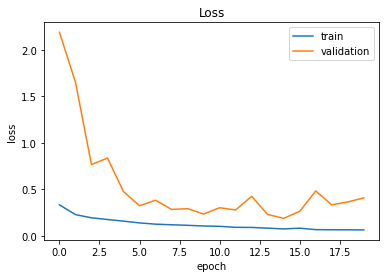

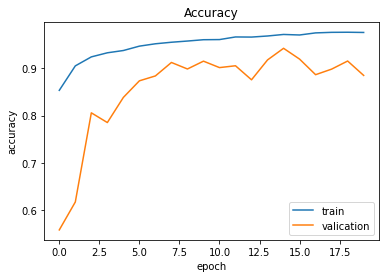

In [ ]:
# relu
inputs = Input(shape=(96,96,3))
relu_mobileNet2 = run_all(relu_mobileNet2(inputs))

In [177]:
# reduce dims
# a = np.array([[[[1,2,3],[1,2,3],[1,2,3],[1,2,3]],
#                [[1,2,3],[1,2,3],[1,2,3],[1,2,3]]]])
# print(a.shape)
# b = np.squeeze(a, axis=0)
# b.shape

(1, 2, 4, 3)


(2, 4, 3)

## M4: CNN-LSTM

In [199]:
INP_SIZE = (96,96)

# default config
lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'elu'
loss = 'binary_crossentropy'
metrics = ['accuracy',
           tf.keras.metrics.AUC(),
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall()
          ]
n_epochs = 20

# build model
def mobileNet2_lstm(input_shape=(INP_SIZE[0],INP_SIZE[1],3), n_class=2):
    tf.autograph.experimental.do_not_convert(func=True)
    
    n_classes = n_class
    input_shape = input_shape
    model_name = 'mobileNet2_lstm'
    
    mobileNet2NN = load_model(path + 'models/mobileNet2NN.h5') #. NN with (elu) output=2
    mobileNet2NN.summary()

    inputs = inputs = Input(shape=(INP_SIZE[0],INP_SIZE[1],3))
    x = mobileNet2NN(inputs, training=False)
    
    # create new shape (224,224,3)
    x = Reshape((1,1,2))(x)
    x = UpSampling2D((96, 96))(x)
    x = Conv2D(64,3)(x)
    x = Conv2D(64,3)(x)
    x = MaxPooling2D(2)(x) #. shape = (None,46,46,64)
    x = Reshape((-1,64))(x) #. shape = (None,2116,46)
    x = LSTM(32)(x)
    
    outputs = layers.Dense(2, activation='sigmoid', name='pred')(x)

    model = Model(inputs=inputs, outputs=outputs, name=model_name)
    model.compile(loss=loss, optimizer = opt, metrics= metrics)
  
    return model

mobileNet2_lstm().summary()

Model: "mobileNet2NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 512)              

In [209]:
path = './'
INP_SIZE = (96,96)

# default config
lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'elu'
loss = 'binary_crossentropy'
metrics = ['accuracy',
           tf.keras.metrics.AUC(),
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall()
          ]
n_epochs = 20

# build model
def mobileNet2_lstm(input_shape=(INP_SIZE[0],INP_SIZE[1],3), n_class=2):
    tf.autograph.experimental.do_not_convert(func=True)
    
    n_classes = n_class
    input_shape = input_shape
    model_name = 'mobileNet2_lstm'
    
    mobileNet2NN = load_model(path + 'models/mobileNet2NN.h5') #. NN with (elu) output=2

    inputs = inputs = Input(shape=(INP_SIZE[0],INP_SIZE[1],3))
    x = mobileNet2NN(inputs, training=False)
    
    # create new shape (224,224,3)
    x = Reshape((1,1,2))(x)
    x = UpSampling2D((96, 96))(x)
    x = Conv2D(64,3)(x)
    x = Conv2D(64,3)(x)
    x = MaxPooling2D(2)(x) #. shape = (None,46,46,64)
    x = Reshape((-1,64))(x) #. shape = (None,2116,46)
    x = LSTM(32)(x)
    
    outputs = layers.Dense(2, activation='sigmoid', name='pred')(x)

    model = Model(inputs=inputs, outputs=outputs, name=model_name)
    model.compile(loss=loss, optimizer = opt, metrics= metrics)
  
    return model

# training pipeline
# save
callbacks = [keras.callbacks.ModelCheckpoint(path + 'checkpoints/pcam_ep{epoch}.h5', 
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode = 'max'
                                             )]
#  train
def train_model(model):
    start = time.time()
    hist = model.fit(train_generator,
                     epochs = n_epochs,
                     verbose = 1, 
                     validation_data = valid_generator,
                     steps_per_epoch = train_steps_per_epoch,
                     validation_steps = valid_steps_per_epoch,
                     shuffle = True,
                     callbacks=callbacks)
    stop = time.time()
    training_time = stop - start
    print(f'Total training time = {training_time}s')
    
    model.save_weights(path + f'models/{model.name}_weights.h5')
    model.save(path + f'models/{model.name}.h5')
    
    return hist, model

# evaluate model loss & accuracy on test set
def eval_model(model):
    score = model.evaluate(test_generator)
    return score

# plot
def plot_model(hist):
    # loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.plot()
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # accuracy
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valication'], loc='lower right')
    plt.show()

# run and test model
def run_all(model):
    tf.autograph.experimental.do_not_convert(func=True)
    hist, model = train_model(model)
    eval_model(model)
    plot_model(hist)

    return model

In [ ]:
tf.autograph.experimental.do_not_convert(func=True)
run_all(mobileNet2_lstm())

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
308/308 [==============================] - ETA: 0s - loss: 0.4110 - accuracy: 0.8340 - auc_5: 0.8955 - precision_5: 0.8323 - recall_5: 0.8300WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8f1cd10dd0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbo

# Evaluation

In [14]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [15]:
# load_models
from tensorflow.keras.models import load_model
tf.autograph.experimental.do_not_convert(func=True)

mobileNet2NN = load_model(path + 'models/mobileNet2NN.h5') #. NN only (elu)
relu_mobileNet2 = load_model(path + 'models/relu_mobileNet2.h5')
selu_mobileNet2 = load_model(path + 'models/selu_mobileNet2.h5')
elu_mobileNet2 = load_model(path + 'models/elu_mobileNet2.h5')

## Compare accuracy

In [24]:
# compare model accuracy
models = [mobileNet2NN, 
          relu_mobileNet2,
          selu_mobileNet2,
          elu_mobileNet2]

def compare_model_accuracy(model_list):
    for i in range(len(model_list)):
        score = eval_model(model_list[i])
        print(f'{model_list[i].name}')
        print(f'loss = {score[0]}, accuracy = {score[1]}\n')
    
compare_model_accuracy(models)
tf.autograph.experimental.do_not_convert(func=True)

103/103 [==============================] - 21s 205ms/step - loss: 0.5500 - accuracy: 0.7563
mobileNet2NN
loss = 0.5500335693359375, accuracy = 0.7563320398330688

103/103 [==============================] - 23s 222ms/step - loss: 2.4323 - accuracy: 0.6273
relu_mobileNet2
loss = 2.4322662353515625, accuracy = 0.6272505521774292

103/103 [==============================] - 24s 232ms/step - loss: 0.9081 - accuracy: 0.8206
base_mobileNet2
loss = 0.9080657362937927, accuracy = 0.8205676078796387

103/103 [==============================] - 23s 225ms/step - loss: 0.4796 - accuracy: 0.8726
elu_mobileNet2
loss = 0.479583203792572, accuracy = 0.8725968599319458



<function tensorflow.python.autograph.impl.api.do_not_convert.<locals>.wrapper(*args, **kwargs)>

In [111]:
# prepare test data
x_test = x_test/255.0
y_true = np.array([np.argmax(i) for i in y_test])

print(x_test.shape)
print(y_true.shape)

(6554, 96, 96, 3)
(6554,)


In [ ]:
tf.autograph.experimental.do_not_convert(func=True)

# elu_mobileNet2.predict(x_test, batch_size=32)
y_hat = np.argmax(elu_mobileNet2.predict(test_generator))

In [1]:
y_hat

NameError: name 'y_hat' is not defined

In [ ]:
# train_ds, validation_ds = tfds.load(
#     "cats_vs_dogs",
#     # Reserve 10% for validation
#     split=["train[:40%]", "train[40%:50%]"],
#     as_supervised=True,
# )

# train_ds = (
#     train_ds.shuffle(BATCH_SIZE * 100)
#     .map(preprocess_dataset, num_parallel_calls=AUTO)
#     .batch(BATCH_SIZE)
#     .prefetch(AUTO)
# )
# validation_ds = (
#     validation_ds.map(preprocess_dataset, num_parallel_calls=AUTO)
#     .batch(BATCH_SIZE)
#     .prefetch(AUTO)
# )

In [ ]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
def get_model():
    backbone = tf.keras.applications.DenseNet121(
        weights=None,
        include_top=True,
        classes=2,
        input_shape=((TARGET_SIZE[0], TARGET_SIZE[1], 3)),
    )
    backbone.trainable = True

    inputs = layers.Input((INP_SIZE[0], INP_SIZE[1], 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)
    x = learnable_resizer(x)
    outputs = backbone(x)

    return tf.keras.Model(inputs, outputs)